In [1]:
import pandas as pd
import os
import numpy as np
import pytz
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import pytz as tz
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.signal import butter, filtfilt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
RESPECK_FILE = '../data/bishkek_csr/03_train_ready/respeck/08-05-2025_respeck.csv'
PSG_FILE = '../data/bishkek_csr/03_train_ready/nasal_files/08-05-2025_nasal.csv'
LABELS_FILE = '../data/bishkek_csr/03_train_ready/event_exports/08-05-2025_event_export.csv'
OUTPUT_FILE = './08-05-2025_respeck_features.csv'

# --- Load Data ---
print("Loading data...")

respeck_df = pd.read_csv(RESPECK_FILE)
respeck_df['timestamp'] = pd.to_datetime(respeck_df['alignedTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
respeck_df['timestamp'] = respeck_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
# respeck_df.set_index('timestamp', inplace=True, drop=False)
print(respeck_df['timestamp'])


psg_df = pd.read_csv(PSG_FILE)
psg_df['timestamp'] = pd.to_datetime(psg_df['UnixTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
psg_df['timestamp'] = psg_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
print(psg_df['timestamp'])
# psg_df.set_index('timestamp', inplace=True)

labels_df = pd.read_csv(LABELS_FILE)
labels_df['timestamp'] = pd.to_datetime(labels_df['UnixTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
labels_df['timestamp'] = labels_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
# labels_df.set_index('timestamp', inplace=True)

Loading data...
0        2025-05-08 00:00:58.562000+06:00
1        2025-05-08 00:00:58.642000+06:00
2        2025-05-08 00:00:58.722000+06:00
3        2025-05-08 00:00:58.802000+06:00
4        2025-05-08 00:00:58.882000+06:00
                       ...               
263419   2025-05-08 05:51:48.255000+06:00
263420   2025-05-08 05:51:48.335000+06:00
263421   2025-05-08 05:51:48.415000+06:00
263422   2025-05-08 05:51:48.495000+06:00
263423   2025-05-08 05:51:48.575000+06:00
Name: timestamp, Length: 263424, dtype: datetime64[ns, Asia/Bishkek]
0                2025-05-07 23:58:33+06:00
1         2025-05-07 23:58:33.010000+06:00
2         2025-05-07 23:58:33.020000+06:00
3         2025-05-07 23:58:33.030000+06:00
4         2025-05-07 23:58:33.040000+06:00
                        ...               
2027795   2025-05-08 05:36:30.950000+06:00
2027796   2025-05-08 05:36:30.960000+06:00
2027797   2025-05-08 05:36:30.970000+06:00
2027798   2025-05-08 05:36:30.980000+06:00
2027799   2025-05-08 05

In [3]:
# forward and back fill respeck data before extraction

start_time_respeck = respeck_df['timestamp'].min()
end_time_respeck = respeck_df['timestamp'].max()

start_time_psg = psg_df['timestamp'].min()
end_time_psg = psg_df['timestamp'].max()

overlap_start = max(start_time_respeck, start_time_psg)
overlap_end = min(end_time_respeck, end_time_psg)


print(overlap_start)
print(overlap_end)

respeck_df = respeck_df[(respeck_df['timestamp'] >= overlap_start) & (respeck_df['timestamp'] <= overlap_end)]
psg_df = psg_df[(psg_df['timestamp'] >= overlap_start) & (psg_df['timestamp'] <= overlap_end)]

# print("\nChecking for and imputing missing values (NaNs)...")
# for col in respeck_df:
#     if col in respeck_df.columns:
#         nan_count = respeck_df[col].isnull().sum()
#         if nan_count > 0:
#             print(f"  - Found {nan_count} NaNs in '{col}'. Applying forward-fill and backward-fill.")
            
#             # Step 1: Forward-fill handles all NaNs except leading ones.
#             respeck_df[col].ffill(inplace=True) 
            
#             # Step 2: Backward-fill handles any remaining NaNs at the beginning of the file.
#             respeck_df[col].bfill(inplace=True) 

# print("  - Applying bandpass filter to breathing signal...")
# respeck_df = respeck_df.sort_values('alignedTimestamp')

# Dynamically calculate the sampling rate from the timestamps
time_diffs_ms = respeck_df['alignedTimestamp'].diff().median()
if pd.isna(time_diffs_ms) or time_diffs_ms == 0:

    fs = 1000.0 / time_diffs_ms  # Sampling frequency in Hz
    print(f"    - Calculated sampling rate: {fs:.2f} Hz")

    # Define filter parameters
    lowcut = 0.1   # Lower cutoff frequency in Hz
    highcut = 1.5  # Upper cutoff frequency in Hz
    order = 2      # Filter order (2 is a good choice to avoid distortion)

    try:
        # Design the Butterworth bandpass filter
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        
        respeck_df['original_breathingSignal'] = respeck_df['breathingSignal']

    # 2. Apply the filter and OVERWRITE the 'breathingSignal' column with the clean data
        respeck_df['breathingSignal'] = filtfilt(b, a, respeck_df['breathingSignal'])

        # Apply the filter and store it in a NEW column
        # We keep the original 'breathingSignal' for reference
        respeck_df['filteredBreathingSignal'] = filtfilt(b, a, respeck_df['breathingSignal'])
    except ValueError as e:
        print(f"  - WARNING: Skipping session. Filter could not be applied. Error: {e}")


2025-05-08 00:00:58.562000+06:00
2025-05-08 05:36:30.990000+06:00


In [4]:
# import pandas as pd
# import plotly.graph_objects as go
# from scipy.signal import butter, filtfilt
# import numpy as np

# # --- 1. Configuration ---
# # Point this to the Respeck file you want to visualize
# RESPECK_FILE_TO_PLOT = RESPECK_FILE
# # How many data points to plot (to keep it fast). Use None to plot everything.
# POINTS_TO_PLOT = None

# # --- 2. Load and Prepare Data ---
# df_plot = pd.read_csv(RESPECK_FILE_TO_PLOT)
# # Use a numeric timestamp for calculations
# df_plot['timestamp_unix'] = df_plot['alignedTimestamp']
# # Create a human-readable datetime column for the plot's x-axis
# df_plot['timestamp_dt'] = pd.to_datetime(df_plot['timestamp_unix'], unit='ms')

# # --- 3. Apply the EXACT same filter logic from makeDataset.py ---
# # Impute NaNs first
# df_plot['breathingSignal'].ffill(inplace=True)
# df_plot['breathingSignal'].bfill(inplace=True)

# # Calculate sampling rate
# fs = 1000.0 / df_plot['timestamp_unix'].diff().median()
# print(f"Calculated Sampling Rate: {fs:.2f} Hz")

# # Design and apply filter
# lowcut, highcut, order = 0.1, 1.5, 2
# nyquist = 0.5 * fs
# b, a = butter(order, [lowcut/nyquist, highcut/nyquist], btype='band')
# df_plot['filteredBreathingSignal'] = filtfilt(b, a, df_plot['breathingSignal'])

# # --- 4. Create the Plot ---
# # Limit the number of points for performance if specified
# if POINTS_TO_PLOT:
#     df_plot = df_plot.head(POINTS_TO_PLOT)

# fig = go.Figure()

# # Add the Original Signal
# fig.add_trace(go.Scatter(
#     x=df_plot['timestamp_dt'],
#     y=df_plot['breathingSignal'],
#     mode='lines',
#     name='Original Signal'
# ))

# # Add the Filtered Signal
# fig.add_trace(go.Scatter(
#     x=df_plot['timestamp_dt'],
#     y=df_plot['filteredBreathingSignal'],
#     mode='lines',
#     name='Filtered Signal (0.1-1.5 Hz)',
#     line=dict(color='red', width=2)
# ))

# # Update layout for a clean look
# fig.update_layout(
#     title='Comparison of Original vs. Filtered Breathing Signal',
#     xaxis_title='Time',
#     yaxis_title='Signal Amplitude',
#     legend_title='Signal Type',
#     template='plotly_white'
# )

# fig.show()

In [5]:
# Jack's Util file

def nans(dims):
    a = np.empty(dims)
    a[:] = np.nan
    return a

''' Find the RMS value of an input signal in array form. '''
def rms(signal):
    return np.sqrt(np.mean(signal**2))

def rmsHamming(signal):
    squares = signal**2
    weights = np.hamming(len(signal))
    weightedSum = 0.0
    weightsSum = 0.0

    for i in range(len(signal)):
        weightedSum += squares[i] * weights[i]
        weightsSum += weights[i]

    return np.sqrt(weightedSum / weightsSum)

''' Find islands of defined values in a signal that may contain NaNs. '''
def findIslandLimits(signal, minIslandLength=0, minIslandGap=0):

    islands = []

    start = None
    end = None
    foundIsland = False

    for i in range(len(signal)):
        if not signal[i]:
            if start == None:
                start = i
            else:
                end = i + 1
                if i == len(signal) - 1:
                    foundIsland = True
        else:
            if start != None:
                if end != None:
                    foundIsland = True
                else:
                    start = None

        if foundIsland:
            if (minIslandGap > 0) and (len(islands) > 0):
                prevIslandStart = islands[-1][0]
                prevIslandEnd = islands[-1][1]
                islandGap = start - prevIslandEnd - 1
                if islandGap < minIslandGap:
                    # merge the new island with the previous one
                    islands[-1] = ((prevIslandStart, end))
                else:
                    islands.append((start, end))
            else:    
                islands.append((start, end))

            start = None
            end = None
            foundIsland = False
            
    # now return only the islands that are long enough
    longIslands = []
    for island in islands:
        if (island[1] - island[0]) >= minIslandLength:
            longIslands.append(island)

    return longIslands

def calculateThresholdLevels(signal, rmsBackwardLength, rmsForwardLength, rmsMultiplier, symmetrical):
    result = nans((len(signal), 2))
    
    if not symmetrical:
        
        #fill sum of squares buffers
        posValues = []
        negValues = []
        windowLength = rmsBackwardLength + rmsForwardLength
        if len(signal) < windowLength:
            return result
        
        lastBananaIndex = np.nan
            
        for i in range(windowLength - 1):
            if signal[i] >= 0:
                posValues.append(signal[i])
            elif signal[i] < 0:
                negValues.append(signal[i])
            else: # if nan
                lastBananaIndex = i
                
        posArray = np.array(posValues)
        negArray = np.array(negValues)
        
        sumOfSquaresPos = np.sum(posArray**2)
        posCount = len(posArray)
        sumOfSquaresNeg = np.sum(negArray**2)
        negCount = len(negArray)
        
        for i in range(0, len(signal)):
            if i < rmsBackwardLength or i >= len(signal) - rmsForwardLength:
                posResult = np.nan
                negResult = np.nan
            else:
                newValue = signal[i+rmsForwardLength-1]
                if np.isnan(newValue):
                    lastBananaIndex = i+rmsForwardLength-1
                else:
                    if newValue >= 0:
                        sumOfSquaresPos += newValue**2
                        posCount += 1
                    elif newValue < 0:
                        sumOfSquaresNeg += newValue**2
                        negCount += 1
                
                if not np.isnan(lastBananaIndex) and i - lastBananaIndex <= rmsBackwardLength:
                    posResult = np.nan
                    negResult = np.nan
                else:
                    posResult = np.sqrt(sumOfSquaresPos / posCount) * rmsMultiplier
                    negResult = -np.sqrt(sumOfSquaresNeg / negCount) * rmsMultiplier
                
                oldValue = signal[i-rmsBackwardLength]
                
                if oldValue >= 0:
                    sumOfSquaresPos -= oldValue**2
                    posCount -= 1
                elif oldValue < 0:
                    sumOfSquaresNeg -= oldValue**2
                    negCount -=1
            result[i,0] = posResult
            result[i,1] = negResult
            
        return result
    
    else:
        #fill sum of squares buffers
        allValues = []
        windowLength = rmsBackwardLength + rmsForwardLength
        if len(signal) < windowLength:
            return result
        
        lastBananaIndex = np.nan
        
        for i in range(windowLength - 1):
            if not np.isnan(signal[i]):
                allValues.append(signal[i])
            else:
                lastBananaIndex = i
        allArray = np.array(allValues)
        
        sumOfSquaresAll = np.sum(allArray**2)
        allCount = len(allArray)
        
        for i in range(0, len(signal)):
            if i < rmsBackwardLength or i >= len(signal) - rmsForwardLength:
                allResult = np.nan
            else:
                newValue = signal[i+rmsForwardLength-1]
                if np.isnan(newValue):
                    lastBananaIndex = i+rmsForwardLength-1
                else:
                    sumOfSquaresAll += newValue**2
                    allCount += 1
                
                if not np.isnan(lastBananaIndex) and i - lastBananaIndex <= rmsBackwardLength:
                    allResult = np.nan
                else:
                    allResult = np.sqrt(sumOfSquaresAll / allCount) * rmsMultiplier
                
                oldValue = signal[i-rmsBackwardLength]
                if not np.isnan(oldValue):
                    sumOfSquaresAll -= oldValue**2
                    allCount -= 1
                    
            result[i,0] = allResult
            result[i,1] = -allResult
        #figure()
        #plot(signal)
        #plot(result)
        #show()
        return result

def calculateBreathTimes(signal, posThresholds, negThresholds, minThreshold, zeroCrossingBreathStart):
    
    def breathTimes(startIndex, endIndex):

        def setInitialState(startValue, posThreshold, negThreshold):
            if startValue < negThreshold:
                state = LOW
            elif startValue > posThreshold:
                state = HIGH
            else:
                state = MID_UNKNOWN
            return state
    
        state = setInitialState(signal[startIndex], posThresholds[startIndex], negThresholds[startIndex])
        times = []
    
        for i in range(startIndex + 1, endIndex + 1):
            posThreshold = posThresholds[i]
            negThreshold = negThresholds[i]
            if state == LOW and signal[i] > negThreshold:
                state = MID_RISING
            elif state == HIGH and signal[i] < posThreshold:
                state = MID_FALLING
            elif (state == MID_RISING or state == MID_UNKNOWN) and signal[i] > posThreshold:
                state = HIGH
            elif (state == MID_FALLING or state == MID_UNKNOWN) and signal[i] < negThreshold:
                state = LOW
                times.append(i)

        if zeroCrossingBreathStart:
            zeroCrossingBreathTimes = []
            for t in times:
                for i in range(t,-1,-1):
                    if signal[i] >= 0:
                        zeroCrossingBreathTimes.append(i)
                        break
            return zeroCrossingBreathTimes
        else:
            return times

    LOW, MID_FALLING, MID_UNKNOWN, MID_RISING, HIGH = range(5)

    
    invalidated = np.ones(np.shape(signal), dtype=bool)
    for i in range(len(invalidated)):
        if posThresholds[i] > minThreshold or negThresholds[i] < -minThreshold:
            invalidated[i] = False
    

    minIslandLength = 0
    islandLimits = findIslandLimits(invalidated, minIslandLength)
    
    times = []
    for (start, end) in islandLimits:
        bt = breathTimes(start, end)
        if len(bt) > 0:
            times.append(bt)

    return times


# Code from Jack Taylor

def countLocalMaximas(values):
    count = 0
    if len(values) < 3:
        return 1
    if len(values) > 1 and values[0] > values[1]:
        count += 1
    if len(values) > 1 and values[-1] > values[-2]:
        count += 1
    for i in range(1, len(values) - 1):
        if values[i] > values[i - 1] and values[i] > values[i + 1]:
            count += 1
    return count

def countLocalMinimas(values):
    count = 0
    if len(values) < 3:
        return 1
    if len(values) > 1 and values[0] < values[1]:
        count += 1
    if len(values) > 1 and values[-1] < values[-2]:
        count += 1
    for i in range(1, len(values) - 1):
        if values[i] < values[i - 1] and values[i] < values[i + 1]:
            count += 1
    return count

def generate_RRV(sliced):
    sliced = sliced.dropna()
    if sliced.size == 0:
        return np.nan
    breathingSignal = sliced.values
    N = breathingSignal.shape[-1]
    y = breathingSignal
    yf = np.fft.fft(y)
    yff = 2.0/N * np.abs(yf[:N//2])
    temp_DCnotremov = yff
    if len(temp_DCnotremov) == 0 or len(temp_DCnotremov) == 1: 
        return 0.0
    else:
        DC = np.amax(temp_DCnotremov)
        maxi = np.argmax(temp_DCnotremov)
        temp_DCremov = np.delete(temp_DCnotremov, maxi)
        H1 = np.amax(temp_DCremov)
        return 100-(H1/DC)*100

def getBreaths(df):
    minThreshold = 0.001
    mult = 0.0125
    
    signal = list(df.breathingSignal)
    
    time_diff = df['timestamp'].diff()
    time_diff.map(lambda x: x.total_seconds()).mean()
    
    window_size = int((20 / time_diff.dropna().apply(lambda x: x.total_seconds()).mean()) // 2)
    threshs = calculateThresholdLevels(list(signal), window_size, window_size, mult, False)
    posThresh = threshs[:, 0]
    negThresh = threshs[:, 1]

    times = calculateBreathTimes(list(signal), posThresh, negThresh, minThreshold, False)

    total = set()
    minBreathLength = float("inf")
    maxBreathLength = float("-inf")
    for i in range(0, len(times)):
        vals = times[i]
        for j in range(0, len(vals)-1):
            start, end = vals[j], vals[j+1]
            minBreathLength = min(minBreathLength, end-start+1)
            maxBreathLength = max(maxBreathLength, end-start+1)
            for k in range(start, end+1):
                total.add(k)

    f = list(df.breathingSignal.dropna())
    a = f"Uses Breath From {len(total)}/{len(f)} = {round((len(total)/len(f)) * 100, 2)}% Signal"
    b = f"Max Breath Length: {maxBreathLength} points. Min Breath Length: {minBreathLength} points"
    print(a)
    print(b)
        
    return times


def mode(l):
    if len(l) == 0:
        return np.NaN, {}, []
    
    sortedRoundedArray = np.sort(np.around(l))
    dict = {}
    dist = np.zeros(sortedRoundedArray[-1] + 1)
    maxCount = 0
    for e in sortedRoundedArray:
        dist[e] += 1
        if e in dict:
            newCount = dict[e] + 1
            dict[e] = newCount
        else:
            newCount = 1
            dict[e] = newCount
            
        if newCount > maxCount:
                maxCount = newCount
    
    if maxCount > 0:
        l = []
        for e in dict:
            if dict[e] == maxCount:
                l.append(e)
        sorted = np.sort(l)
        return sorted[len(sorted) // 2], dict, dist
                
    else:
        return np.NaN, dict, dist
    

def extractFeatures(df):
    times = getBreaths(df)

    areas = []
    extremas = []
    peakRespiratoryFlows = []
    types = []
    durations = []
    activityLevels = []
    activityTypes = []
    starts = []
    ends = []
    
    activityLevel = np.array(df.activityLevel)
    activityType = np.array(df.activityType)
    signal = np.array(df.breathingSignal)
    timestamps = list(df.timestamp)

    for i in range(0, len(times)):
        if i % 25 == 0:
            print(f"{i}/{len(times)}... ", end=" ")
        vals = times[i]
        
        for j in range(0, len(vals)-1):
            start, end = vals[j], vals[j+1]
            flag = False
            breath = signal[start:end+1]
            breakPoint = start
            for k, val in enumerate(breath):
                if val >= 0.005: # arbitrary but to remove noise...
                    breakPoint = start + k
                    break

            # compute inhalation
            inhalation, inhalation_times = signal[start:breakPoint], timestamps[start:breakPoint]
            exhalation, exhalation_times = signal[breakPoint:end+1], timestamps[breakPoint:end+1]
                    
            level = activityLevel[start:end+1].mean()
            modeType = mode(activityType[start:end+1])[0]
            
            # compute inhalation
            if len(inhalation) > 1:
                peak = max(abs(np.array(inhalation)))
                extrema = countLocalMaximas(inhalation)
                dx = (inhalation_times[-1]-inhalation_times[0]).total_seconds() / len(inhalation)
                area = abs(np.trapezoid(y=inhalation,dx=dx))
                duration = (inhalation_times[-1]-inhalation_times[0]).total_seconds()
                
                areas.append(area)
                extremas.append(extrema)
                peakRespiratoryFlows.append(peak)
                types.append("Inhalation")
                durations.append(duration)
                activityLevels.append(level)
                activityTypes.append(modeType)
                starts.append(inhalation_times[0])
                ends.append(inhalation_times[-1])

            if len(exhalation) > 1:
                peak = max(abs(np.array(exhalation)))
                extrema = countLocalMinimas(exhalation)    
                dx = (exhalation_times[-1]-exhalation_times[0]).total_seconds() / len(exhalation)
                area = abs(np.trapezoid(y=exhalation,dx=dx))  
                duration = (exhalation_times[-1]-exhalation_times[0]).total_seconds()
                
                areas.append(area)
                extremas.append(extrema)
                peakRespiratoryFlows.append(peak)
                types.append("Exhalation")
                durations.append(duration)
                activityLevels.append(level)
                activityTypes.append(modeType)
                starts.append(exhalation_times[0])
                ends.append(exhalation_times[-1])

    return pd.DataFrame(data={"type": types, "area": areas, "peakRespiratoryFlow": peakRespiratoryFlows, "extremas": extremas, "duration": durations, "meanActivityLevel": activityLevels, "modeActivityType": activityTypes, "startTimestamp": starts, "endTimestamp": ends})


def getRegularity(df):
    # get distance to 1st PC for area, PRF only --> makes rapid shallow in feature level
    # make it temporal by adding distance to PC from all 3 as a seperaate PCA raansform
    scaler = MinMaxScaler()
    columns = ['area', 'peakRespiratoryFlow']
    df_normalized = scaler.fit_transform(df[columns])
    pca = PCA(n_components=1)  
    pca.fit(df_normalized)
    df_pca = pca.transform(df_normalized)
    first_principal_component = pca.components_[0]
    te = np.linalg.norm(df_normalized - np.outer(df_normalized.dot(first_principal_component), first_principal_component), axis=1)

    scaler = MinMaxScaler()
    
    # Okay so we are looking at the resapmled breathing rate
    columns = ['area', 'peakRespiratoryFlow', 'BR_mean']
    df_normalized = scaler.fit_transform(df[columns])
    pca = PCA(n_components=3)  
    pca.fit(df_normalized)
    df_pca = pca.transform(df_normalized)
    
    first_principal_component = pca.components_[0]
    second_principal_component = pca.components_[1]
    third_principal_component = pca.components_[2]
    
    distances_to_first_component = np.linalg.norm(df_normalized - np.outer(df_normalized.dot(first_principal_component), first_principal_component), axis=1)
    distances_to_second_component = np.linalg.norm(df_normalized - np.outer(df_normalized.dot(second_principal_component), second_principal_component), axis=1)
    distances_to_third_component = np.linalg.norm(df_normalized - np.outer(df_normalized.dot(third_principal_component), third_principal_component), axis=1)

    # Linear combination of these distances
    distances_difference = te + (distances_to_first_component - distances_to_second_component + distances_to_third_component)

    distances_difference = (distances_difference - distances_difference.min()) / (distances_difference.max() - distances_difference.min())
    
    return 1 - distances_difference

def combineDfs(respeck_df, original_respeck_df):
    breath_averages = []
    
    original_respeck_df.set_index('timestamp', inplace=True)
    original_respeck_df['BR_md'] = original_respeck_df[['breathingRate']].resample('30s').median().reindex(original_respeck_df.index, method='nearest')
    original_respeck_df['BR_mean'] = original_respeck_df[['breathingRate']].resample('30s').mean().reindex(original_respeck_df.index, method='nearest')
    original_respeck_df['BR_std'] = original_respeck_df[['breathingRate']].resample('30s').std().reindex(original_respeck_df.index, method='nearest')

    original_respeck_df['AL_md'] = original_respeck_df[['activityLevel']].resample('30s').median().reindex(original_respeck_df.index, method='nearest')
    original_respeck_df['AL_mean'] = original_respeck_df[['activityLevel']].resample('30s').mean().reindex(original_respeck_df.index, method='nearest')
    original_respeck_df['AL_std'] = original_respeck_df[['activityLevel']].resample('30s').std().reindex(original_respeck_df.index, method='nearest')


    RRV = original_respeck_df[["breathingSignal"]].resample('30s').apply(generate_RRV)
    RRV = RRV.replace(0, np.nan).ffill().bfill()
    original_respeck_df['RRV'] = RRV.reindex(original_respeck_df.index, method='nearest')

    # average of 3 Neighbours
    RRV3MA = RRV.rolling(window=3, center = True).mean() * 0.65
    original_respeck_df['RRV3MA'] = RRV3MA.reindex(original_respeck_df.index, method='nearest')
    
    original_respeck_df = original_respeck_df.reset_index()
    
    for index, row in respeck_df.iterrows():
        start_timestamp_str = row['startTimestamp']
        end_timestamp_str = row['endTimestamp']

        start_timestamp = pd.to_datetime(start_timestamp_str)
        end_timestamp = pd.to_datetime(end_timestamp_str)

        
        filtered_df = original_respeck_df[
            (original_respeck_df['timestamp'] >= start_timestamp) &
            (original_respeck_df['timestamp'] <= end_timestamp)
        ]
        """
        get sleeping features
        """
        breath_averages.append({
            'type': row['type'],
            'startTimestamp': start_timestamp,
            'endTimestamp': end_timestamp,
            'area': row['area'],
            'extremas': row['extremas'],
            'meanActivityLevel': row['meanActivityLevel'],
            'modeActivityType': row['modeActivityType'],
            'peakRespiratoryFlow': row['peakRespiratoryFlow'],
            'duration': row['duration'],
            'BR_md': filtered_df.BR_md.mean(),
            'BR_mean': filtered_df.BR_mean.mean(),
            'BR_std': filtered_df.BR_std.mean(),
            'AL_md': filtered_df.AL_md.mean(),
            'AL_mean': filtered_df.AL_mean.mean(),
            'AL_std': filtered_df.AL_std.mean(),
            'RRV': filtered_df.RRV.mean(),
            'RRV3MA': filtered_df.RRV3MA.mean(),
        })
    breath_averages_df = pd.DataFrame(breath_averages)
    return breath_averages_df

In [6]:

def calculate_breathing_rate_from_breaths(df, breath_times, window_minutes=1):
    """
    Calculate breathing rate from detected breath times.
    
    Parameters:
    - df: DataFrame with timestamp and breathingSignal columns
    - breath_times: Output from getBreaths function
    - window_minutes: Time window for rate calculation in minutes
    
    Returns:
    - DataFrame with timestamp and calculated breathing rate
    """
    # Convert timestamps to datetime

    df['datetime'] = df['timestamp']
    
    # Flatten all breath indices
    all_breath_indices = []
    for breath_group in breath_times:
        all_breath_indices.extend(breath_group)
    
    # Sort breath indices
    all_breath_indices.sort()
    
    # Create breathing rate time series
    breathing_rates = []
    timestamps = []
    
    # Calculate rate using sliding window
    window_seconds = window_minutes * 60
    
    for i, breath_idx in enumerate(all_breath_indices):
        if breath_idx >= len(df):
            continue
            
        current_time = df.iloc[breath_idx]['datetime']
        timestamps.append(df.iloc[breath_idx]['timestamp'])
        
        # Count breaths in the past window
        breath_count = 0
        for j in range(i, -1, -1):  # Look backwards
            if all_breath_indices[j] >= len(df):
                continue
            breath_time = df.iloc[all_breath_indices[j]]['datetime']
            time_diff = (current_time - breath_time).total_seconds()
            
            if time_diff <= window_seconds:
                breath_count += 1
            else:
                break
        
        # Convert to breaths per minute
        rate = (breath_count / window_seconds) * 60
        breathing_rates.append(rate)
    
    # Create result DataFrame
    result_df = pd.DataFrame({
        'timestamp': timestamps,
        'calculated_breathing_rate': breathing_rates
    })
    
    return result_df

In [ ]:
# Extract features

breath_features = extractFeatures(respeck_df)
print(breath_features)
# features_df = combineDfs(breath_features, respeck_df)
# breath_regularity_feature = getRegularity(features_df)
# print(breath_regularity_feature)

Uses Breath From 122628/251385 = 48.78% Signal
Max Breath Length: 133 points. Min Breath Length: 5 points
0/219...  25/219...  50/219...  75/219...  100/219...  125/219...  150/219...  175/219...  200/219...              type       area  peakRespiratoryFlow  extremas  duration  \
0     Inhalation   0.081855             0.129082         2      0.96   
1     Exhalation   0.097361             0.142153         2      1.28   
2     Inhalation   0.092574             0.137808         3      0.96   
3     Exhalation   0.100829             0.143393         2      1.28   
4     Inhalation   0.112738             0.160019         2      1.12   
...          ...        ...                  ...       ...       ...   
5599  Exhalation   0.878046             1.798095        14      4.40   
5600  Inhalation  12.267042            10.288965         3      3.28   
5601  Exhalation  10.739278             9.595699         2      2.16   
5602  Inhalation   0.866933             1.052176         2      1.44   

In [8]:
# Convert 'startTimestamp' to datetime
breath_features['startTimestamp'] = pd.to_datetime(breath_features['startTimestamp'])

# Count the number of breaths (inhalations + exhalations)
breath_features['breath_count'] = 1  # Each row corresponds to a breath

# Total number of breaths
total_breaths = breath_features['breath_count'].sum()

# Get the total duration of the DataFrame in minutes
start_time = breath_features['startTimestamp'].min()
end_time = breath_features['startTimestamp'].max()
total_duration_minutes = (end_time - start_time).total_seconds() / 60  # Convert to minutes

# Calculate average breaths per minute
if total_duration_minutes > 0:
    avg_breaths_per_minute = total_breaths / total_duration_minutes
else:
    avg_breaths_per_minute = 0

print(f'Total Breaths: {total_breaths}')
print(f'Total Duration (minutes): {total_duration_minutes:.2f}')
print(f'Average Breaths per Minute: {avg_breaths_per_minute:.2f}')

Total Breaths: 5604
Total Duration (minutes): 335.09
Average Breaths per Minute: 16.72


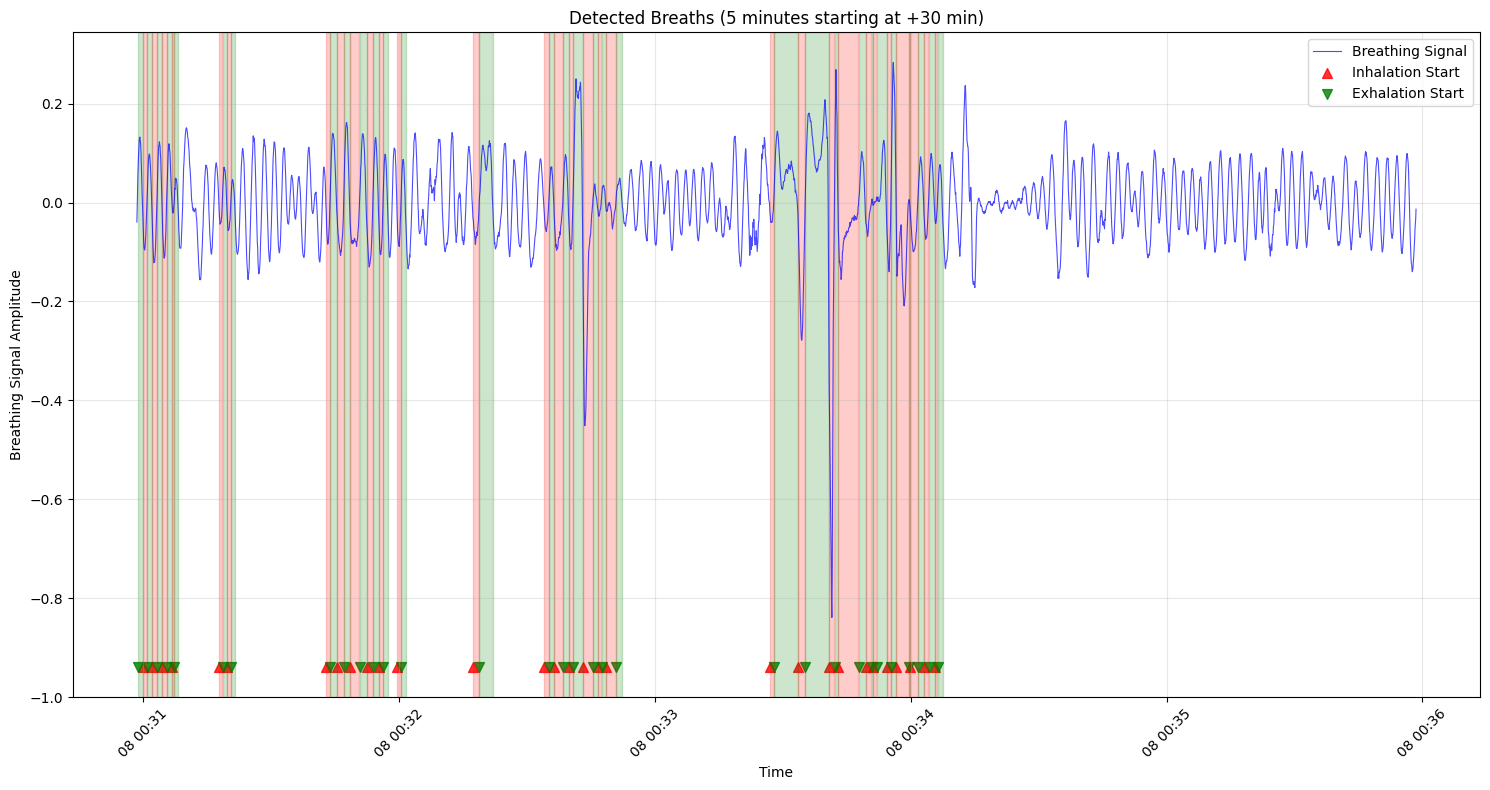


Statistics for 5-minute window:
Inhalations detected: 30
Exhalations detected: 31
Total breath events: 61
Estimated breathing rate: 12.2 breaths/minute


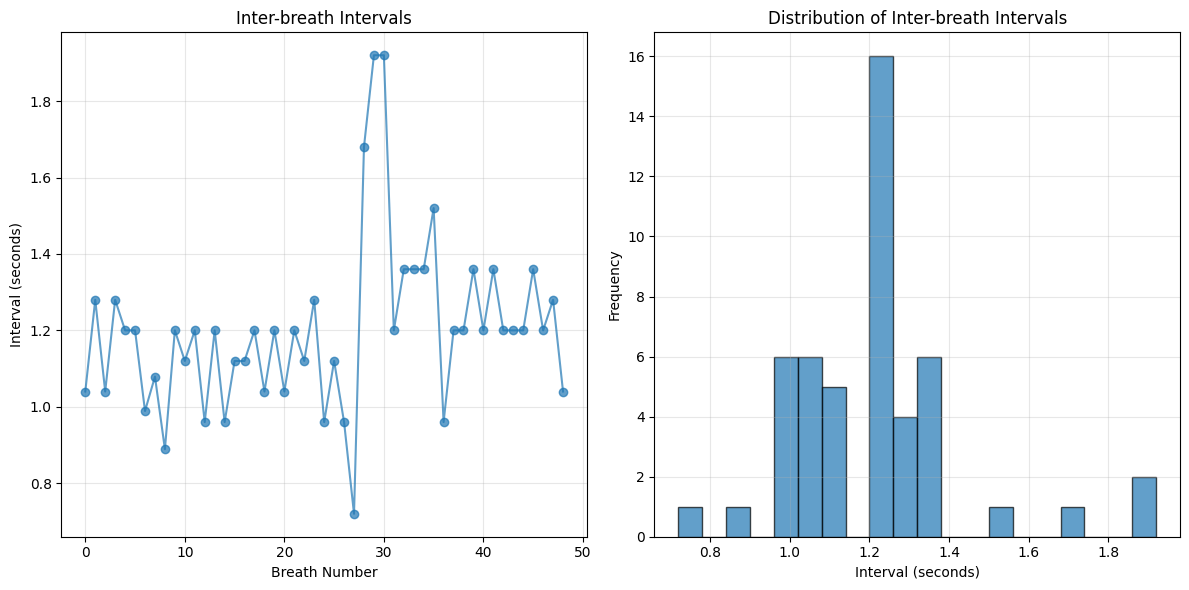

Average interval: 1.20 seconds
Standard deviation: 0.22 seconds
Estimated breathing rate: 50.0 breaths/minute


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta

def plot_detected_breaths(respeck_df, breath_features, start_minutes=0, duration_minutes=5):
    """
    Plot the breathing signal with detected breaths overlaid.
    
    Parameters:
    - respeck_df: DataFrame with timestamp and breathingSignal
    - breath_features: DataFrame from extractFeatures() with startTimestamp, endTimestamp, type
    - start_minutes: Start time offset in minutes from beginning of data
    - duration_minutes: How many minutes of data to plot
    """
    
    # Convert timestamps to datetime if they aren't already
    respeck_df['timestamp'] = pd.to_datetime(respeck_df['timestamp'])
    breath_features['startTimestamp'] = pd.to_datetime(breath_features['startTimestamp'])
    breath_features['endTimestamp'] = pd.to_datetime(breath_features['endTimestamp'])
    
    # Define the time window to plot
    data_start = respeck_df['timestamp'].min()
    plot_start = data_start + timedelta(minutes=start_minutes)
    plot_end = plot_start + timedelta(minutes=duration_minutes)
    
    # Filter the data for the plotting window
    signal_subset = respeck_df[
        (respeck_df['timestamp'] >= plot_start) & 
        (respeck_df['timestamp'] <= plot_end)
    ].copy()
    
    breaths_subset = breath_features[
        (breath_features['startTimestamp'] >= plot_start) & 
        (breath_features['startTimestamp'] <= plot_end)
    ].copy()
    
    if signal_subset.empty:
        print("No data in the specified time range. Try adjusting start_minutes.")
        return
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    
    # Plot the breathing signal
    plt.plot(signal_subset['timestamp'], signal_subset['breathingSignal'], 
             'b-', linewidth=0.8, label='Breathing Signal', alpha=0.7)
    
    # Plot detected breaths
    colors = {'Inhalation': 'red', 'Exhalation': 'green'}
    markers = {'Inhalation': '^', 'Exhalation': 'v'}
    
    for breath_type in ['Inhalation', 'Exhalation']:
        type_breaths = breaths_subset[breaths_subset['type'] == breath_type]
        if not type_breaths.empty:
            plt.scatter(type_breaths['startTimestamp'], 
                       [signal_subset['breathingSignal'].min() - 0.1] * len(type_breaths),
                       c=colors[breath_type], marker=markers[breath_type], 
                       s=50, label=f'{breath_type} Start', alpha=0.8)
    
    # Add breath duration bars
    for _, breath in breaths_subset.iterrows():
        color = colors[breath['type']]
        plt.axvspan(breath['startTimestamp'], breath['endTimestamp'], 
                   alpha=0.2, color=color)
    
    plt.xlabel('Time')
    plt.ylabel('Breathing Signal Amplitude')
    plt.title(f'Detected Breaths ({duration_minutes} minutes starting at +{start_minutes} min)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print some statistics for this window
    inhalations = breaths_subset[breaths_subset['type'] == 'Inhalation']
    exhalations = breaths_subset[breaths_subset['type'] == 'Exhalation']
    
    print(f"\nStatistics for {duration_minutes}-minute window:")
    print(f"Inhalations detected: {len(inhalations)}")
    print(f"Exhalations detected: {len(exhalations)}")
    print(f"Total breath events: {len(breaths_subset)}")
    print(f"Estimated breathing rate: {(len(inhalations) + len(exhalations)) / duration_minutes:.1f} breaths/minute")


def plot_breath_intervals(breath_features, max_breaths=50):
    """
    Plot the intervals between consecutive breaths to check for regularity.
    """
    # Sort by start timestamp
    breath_features_sorted = breath_features.sort_values('startTimestamp')
    
    # Calculate intervals between consecutive breaths (all types)
    intervals = []
    prev_time = None
    
    for _, breath in breath_features_sorted.head(max_breaths).iterrows():
        current_time = breath['startTimestamp']
        if prev_time is not None:
            interval = (current_time - prev_time).total_seconds()
            intervals.append(interval)
        prev_time = current_time
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(intervals, 'o-', alpha=0.7)
    plt.xlabel('Breath Number')
    plt.ylabel('Interval (seconds)')
    plt.title('Inter-breath Intervals')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(intervals, bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Interval (seconds)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Inter-breath Intervals')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Average interval: {np.mean(intervals):.2f} seconds")
    print(f"Standard deviation: {np.std(intervals):.2f} seconds")
    print(f"Estimated breathing rate: {60/np.mean(intervals):.1f} breaths/minute")


def plot_threshold_visualization(respeck_df, start_minutes=0, duration_minutes=2):
    """
    Visualize the adaptive thresholds used by the algorithm.
    """
    # This recreates the threshold calculation from your algorithm
    minThreshold = 0.001
    mult = 0.01
    
    signal = list(respeck_df.breathingSignal)
    
    time_diff = respeck_df['timestamp'].diff()
    window_size = int((10 / time_diff.dropna().apply(lambda x: x.total_seconds()).mean()) // 2)
    
    # Calculate thresholds (using the functions from your code)
    threshs = calculateThresholdLevels(list(signal), window_size, window_size, mult, False)
    posThresh = threshs[:, 0]
    negThresh = threshs[:, 1]
    
    # Define the time window to plot
    data_start = respeck_df['timestamp'].min()
    plot_start = data_start + timedelta(minutes=start_minutes)
    plot_end = plot_start + timedelta(minutes=duration_minutes)
    
    # Get indices for the time window
    start_idx = respeck_df[respeck_df['timestamp'] >= plot_start].index[0]
    end_idx = respeck_df[respeck_df['timestamp'] <= plot_end].index[-1]
    
    # Plot
    plt.figure(figsize=(15, 8))
    
    timestamps = respeck_df.loc[start_idx:end_idx, 'timestamp']
    signal_subset = respeck_df.loc[start_idx:end_idx, 'breathingSignal']
    pos_thresh_subset = posThresh[start_idx:end_idx]
    neg_thresh_subset = negThresh[start_idx:end_idx]
    
    plt.plot(timestamps, signal_subset, 'b-', linewidth=1, label='Breathing Signal')
    plt.plot(timestamps, pos_thresh_subset, 'r--', linewidth=1, label='Positive Threshold', alpha=0.8)
    plt.plot(timestamps, neg_thresh_subset, 'g--', linewidth=1, label='Negative Threshold', alpha=0.8)
    plt.axhline(y=minThreshold, color='orange', linestyle=':', label=f'Min Threshold ({minThreshold})')
    plt.axhline(y=-minThreshold, color='orange', linestyle=':', alpha=0.8)
    
    plt.xlabel('Time')
    plt.ylabel('Signal Amplitude')
    plt.title(f'Breathing Signal with Adaptive Thresholds (mult={mult}, window={window_size})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Usage examples:
# # Plot 5 minutes of data starting from the beginning
# plot_detected_breaths(respeck_df, breath_features, start_minutes=0, duration_minutes=5)

# Plot 5 minutes starting from 30 minutes into the data
plot_detected_breaths(respeck_df, breath_features, start_minutes=30, duration_minutes=5)

# Plot breath intervals
plot_breath_intervals(breath_features)

# Plot thresholds
#plot_threshold_visualization(respeck_df, start_minutes=0, duration_minutes=2)

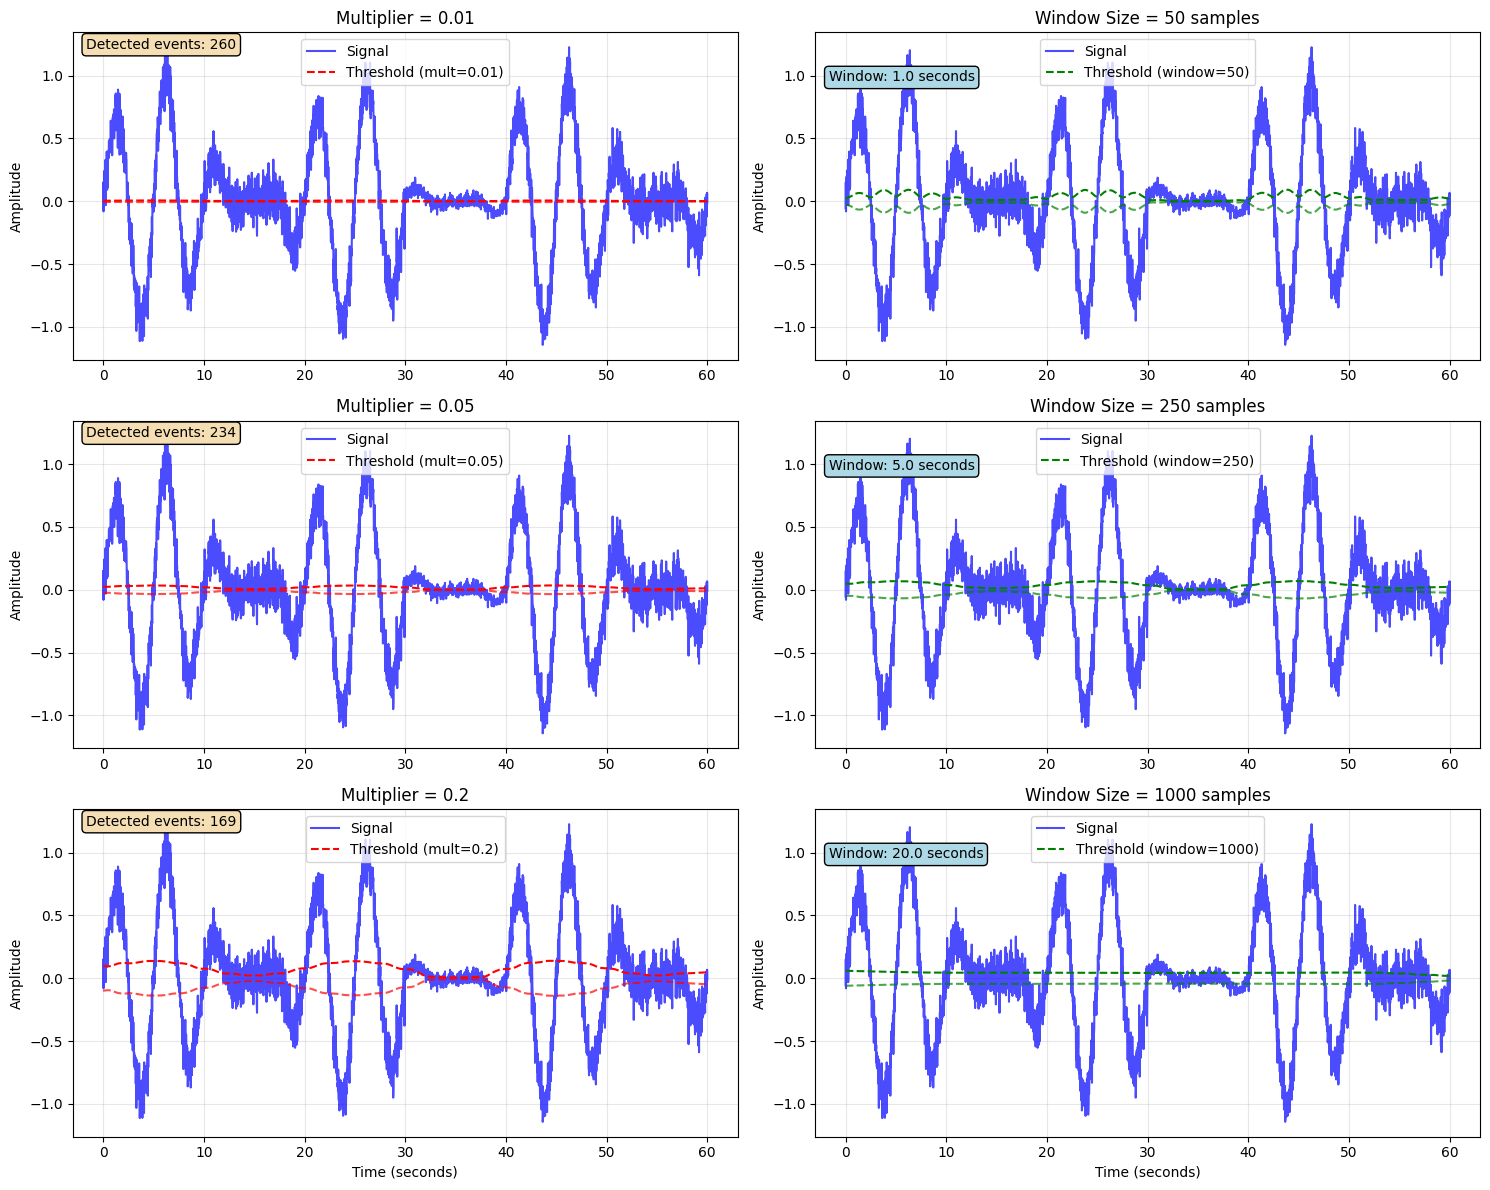

MULTIPLIER EFFECTS (Left Column):
• mult = 0.01: Very sensitive, catches small variations and noise
• mult = 0.05: Moderate sensitivity, good for normal breathing
• mult = 0.2:  Low sensitivity, may miss shallow breaths

WINDOW SIZE EFFECTS (Right Column):
• Small window (1 sec): Highly adaptive, follows signal changes quickly
• Medium window (5 sec): Balanced adaptation, stable but responsive
• Large window (20 sec): Very stable, slow to adapt to changes

TRADE-OFFS:
• Small mult + Small window: Very sensitive, may over-detect
• Large mult + Large window: Very conservative, may under-detect
• Medium values: Usually the sweet spot for real breathing signals


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def demonstrate_parameter_effects():
    """
    Demonstrate how mult and window_size affect breath detection
    """
    
    # Create a synthetic breathing signal with varying amplitudes
    time = np.linspace(0, 60, 3000)  # 1 minute at ~50Hz sampling
    # Main breathing pattern (0.2 Hz = 12 breaths/min)
    breathing = np.sin(2 * np.pi * 0.2 * time)
    
    # Add some amplitude variation (simulating deeper/shallower breaths)
    amplitude_variation = 0.5 + 0.5 * np.sin(2 * np.pi * 0.05 * time)
    breathing = breathing * amplitude_variation
    
    # Add some noise
    noise = 0.1 * np.random.randn(len(time))
    signal = breathing + noise
    
    # Add a period of very shallow breathing
    shallow_start, shallow_end = 1500, 2000
    signal[shallow_start:shallow_end] *= 0.3
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    # Different multiplier values
    multipliers = [0.01, 0.05, 0.2]
    window_samples = 250  # Fixed window for multiplier comparison
    
    for i, mult in enumerate(multipliers):
        ax = axes[i, 0]
        
        # Simple threshold calculation (simplified version)
        window_half = window_samples // 2
        thresholds_pos = []
        thresholds_neg = []
        
        for j in range(len(signal)):
            start_idx = max(0, j - window_half)
            end_idx = min(len(signal), j + window_half)
            window_signal = signal[start_idx:end_idx]
            
            # Calculate RMS and apply multiplier
            rms_val = np.sqrt(np.mean(window_signal**2))
            threshold = rms_val * mult
            
            thresholds_pos.append(threshold)
            thresholds_neg.append(-threshold)
        
        # Plot signal and thresholds
        ax.plot(time, signal, 'b-', alpha=0.7, label='Signal')
        ax.plot(time, thresholds_pos, 'r--', label=f'Threshold (mult={mult})')
        ax.plot(time, thresholds_neg, 'r--', alpha=0.7)
        ax.set_title(f'Multiplier = {mult}')
        ax.set_ylabel('Amplitude')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Count threshold crossings (simplified breath detection)
        crossings = 0
        above_threshold = False
        for j in range(1, len(signal)):
            if signal[j] > thresholds_pos[j] and not above_threshold:
                crossings += 1
                above_threshold = True
            elif signal[j] < thresholds_neg[j]:
                above_threshold = False
        
        ax.text(0.02, 0.95, f'Detected events: {crossings}', 
                transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
    
    # Different window sizes
    window_sizes = [50, 250, 1000]  # Small, medium, large windows
    mult_fixed = 0.1  # Fixed multiplier for window comparison
    
    for i, window_samples in enumerate(window_sizes):
        ax = axes[i, 1]
        
        window_half = window_samples // 2
        thresholds_pos = []
        thresholds_neg = []
        
        for j in range(len(signal)):
            start_idx = max(0, j - window_half)
            end_idx = min(len(signal), j + window_half)
            window_signal = signal[start_idx:end_idx]
            
            # Calculate RMS and apply multiplier
            rms_val = np.sqrt(np.mean(window_signal**2))
            threshold = rms_val * mult_fixed
            
            thresholds_pos.append(threshold)
            thresholds_neg.append(-threshold)
        
        # Plot signal and thresholds
        ax.plot(time, signal, 'b-', alpha=0.7, label='Signal')
        ax.plot(time, thresholds_pos, 'g--', label=f'Threshold (window={window_samples})')
        ax.plot(time, thresholds_neg, 'g--', alpha=0.7)
        ax.set_title(f'Window Size = {window_samples} samples')
        ax.set_ylabel('Amplitude')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Show window size in time
        window_time = window_samples / 50  # Assuming 50 Hz sampling
        ax.text(0.02, 0.85, f'Window: {window_time:.1f} seconds', 
                transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor='lightblue'))
    
    # Add x-axis labels to bottom plots
    for ax in axes[2, :]:
        ax.set_xlabel('Time (seconds)')
    
    plt.tight_layout()
    plt.show()
    
    # Print explanations
    print("MULTIPLIER EFFECTS (Left Column):")
    print("• mult = 0.01: Very sensitive, catches small variations and noise")
    print("• mult = 0.05: Moderate sensitivity, good for normal breathing")
    print("• mult = 0.2:  Low sensitivity, may miss shallow breaths")
    print()
    print("WINDOW SIZE EFFECTS (Right Column):")
    print("• Small window (1 sec): Highly adaptive, follows signal changes quickly")
    print("• Medium window (5 sec): Balanced adaptation, stable but responsive")
    print("• Large window (20 sec): Very stable, slow to adapt to changes")
    print()
    print("TRADE-OFFS:")
    print("• Small mult + Small window: Very sensitive, may over-detect")
    print("• Large mult + Large window: Very conservative, may under-detect") 
    print("• Medium values: Usually the sweet spot for real breathing signals")

# Run the demonstration
demonstrate_parameter_effects()

BREATH DETECTION DIAGNOSTIC REPORT
1. DATA QUALITY:
   Total data points: 252278
   Data duration: 5.6 hours
   NaN values: 893 (0.4%)
   Signal range: -18.052038 to 12.374890
   Signal mean: 0.001156
   Signal std: 0.341553
   Signal RMS: 0.341554

2. SAMPLING:
   Average sample period: 0.080 seconds
   Estimated sampling rate: 12.5 Hz

3. SIGNAL CHARACTERISTICS:
   Zero crossings in derivative: 32309
   Estimated oscillations per minute: 96.3

4. THRESHOLD ANALYSIS:
   Threshold range (mult=0.001): -0.004790 to 0.004790
   Signal exceeds positive threshold: 120424 times
   Signal below negative threshold: 116558 times

5. RECOMMENDED ACTIONS:
   - Plot a sample of your signal to visually inspect breathing patterns
   - Check if signal needs preprocessing (filtering, detrending)
   - Verify data units and scaling
   - Consider if algorithm assumptions match your signal characteristics
{'signal_stats': {'min': np.float64(-18.052038), 'max': np.float64(12.37489), 'mean': np.float64(0.00

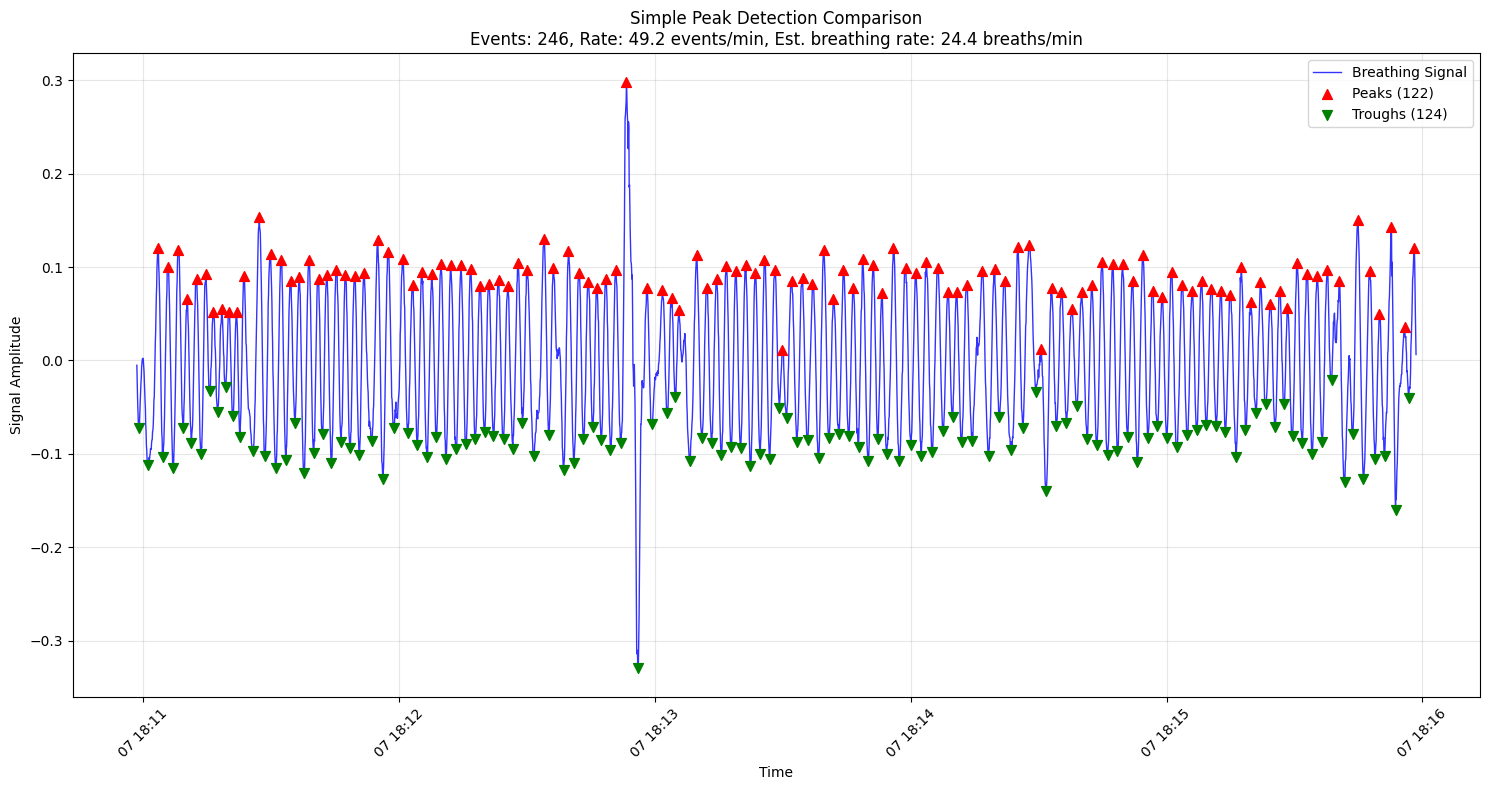

{'peaks': 122, 'troughs': 124, 'events_per_minute': 49.2, 'breaths_per_minute': 24.4}


In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def diagnose_breath_detection_issues(df, sample_minutes=5):
    """
    Comprehensive diagnosis of why breath detection is failing
    """
    print("BREATH DETECTION DIAGNOSTIC REPORT")
    print("=" * 50)
    
    # 1. Data Quality Check
    print("1. DATA QUALITY:")
    print(f"   Total data points: {len(df)}")
    print(f"   Data duration: {(df['timestamp'].max() - df['timestamp'].min()).total_seconds()/3600:.1f} hours")
    
    # Check for NaN values
    nan_count = df['breathingSignal'].isna().sum()
    print(f"   NaN values: {nan_count} ({nan_count/len(df)*100:.1f}%)")
    
    # Check signal range and characteristics
    signal = df['breathingSignal'].dropna()
    print(f"   Signal range: {signal.min():.6f} to {signal.max():.6f}")
    print(f"   Signal mean: {signal.mean():.6f}")
    print(f"   Signal std: {signal.std():.6f}")
    print(f"   Signal RMS: {np.sqrt(np.mean(signal**2)):.6f}")
    
    # 2. Sampling Rate Check
    time_diffs = df['timestamp'].diff().dropna()
    avg_sample_period = time_diffs.apply(lambda x: x.total_seconds()).mean()
    sampling_rate = 1 / avg_sample_period if avg_sample_period > 0 else 0
    print(f"\n2. SAMPLING:")
    print(f"   Average sample period: {avg_sample_period:.3f} seconds")
    print(f"   Estimated sampling rate: {sampling_rate:.1f} Hz")
    
    # 3. Signal Variability Check
    print(f"\n3. SIGNAL CHARACTERISTICS:")
    
    # Check if signal has breathing-like oscillations
    signal_diff = np.diff(signal)
    zero_crossings = np.sum(np.diff(np.signbit(signal_diff)))
    expected_crossings_per_minute = zero_crossings / (len(df) * avg_sample_period / 60)
    print(f"   Zero crossings in derivative: {zero_crossings}")
    print(f"   Estimated oscillations per minute: {expected_crossings_per_minute:.1f}")
    
    # 4. Threshold Analysis
    print(f"\n4. THRESHOLD ANALYSIS:")
    
    # Test with extremely low thresholds
    mult_test = 0.001  # Very low threshold
    window_size = int((10 / avg_sample_period) // 2)
    
    threshs = calculateThresholdLevels(list(signal), window_size, window_size, mult_test, True)
    posThresh = threshs[:, 0]
    negThresh = threshs[:, 1]
    
    valid_pos_thresh = posThresh[~np.isnan(posThresh)]
    valid_neg_thresh = negThresh[~np.isnan(negThresh)]
    
    if len(valid_pos_thresh) > 0:
        print(f"   Threshold range (mult={mult_test}): {valid_neg_thresh.min():.6f} to {valid_pos_thresh.max():.6f}")
        print(f"   Signal exceeds positive threshold: {np.sum(signal > valid_pos_thresh.max())} times")
        print(f"   Signal below negative threshold: {np.sum(signal < valid_neg_thresh.min())} times")
    else:
        print("   ⚠️  No valid thresholds calculated!")
    
    # 5. Visual Inspection Helper
    print(f"\n5. RECOMMENDED ACTIONS:")
    print("   - Plot a sample of your signal to visually inspect breathing patterns")
    print("   - Check if signal needs preprocessing (filtering, detrending)")
    print("   - Verify data units and scaling")
    print("   - Consider if algorithm assumptions match your signal characteristics")
    
    return {
        'signal_stats': {
            'min': signal.min(),
            'max': signal.max(),
            'mean': signal.mean(),
            'std': signal.std(),
            'rms': np.sqrt(np.mean(signal**2))
        },
        'sampling_rate': sampling_rate,
        'zero_crossings_per_minute': expected_crossings_per_minute
    }

def plot_signal_with_simple_detection(df, start_minutes=10, duration_minutes=5):
    """
    Plot signal with very simple peak detection for comparison
    """
    from scipy.signal import find_peaks
    
    # Get time window
    data_start = df['timestamp'].min()
    plot_start = data_start + pd.Timedelta(minutes=start_minutes)
    plot_end = plot_start + pd.Timedelta(minutes=duration_minutes)
    
    # Filter data
    plot_df = df[(df['timestamp'] >= plot_start) & (df['timestamp'] <= plot_end)].copy()
    
    if plot_df.empty:
        print("No data in specified window")
        return
    
    signal = plot_df['breathingSignal'].values
    timestamps = plot_df['timestamp'].values
    
    # Simple peak detection for comparison
    # Find peaks (inspiration)
    peaks, _ = find_peaks(signal, height=np.std(signal)*0.1, distance=20)
    # Find troughs (expiration)  
    troughs, _ = find_peaks(-signal, height=np.std(signal)*0.1, distance=20)
    
    plt.figure(figsize=(15, 8))
    
    # Plot signal
    plt.plot(timestamps, signal, 'b-', linewidth=1, label='Breathing Signal', alpha=0.8)
    
    # Plot detected peaks and troughs
    if len(peaks) > 0:
        plt.scatter(timestamps[peaks], signal[peaks], c='red', marker='^', 
                   s=50, label=f'Peaks ({len(peaks)})', zorder=5)
    
    if len(troughs) > 0:
        plt.scatter(timestamps[troughs], signal[troughs], c='green', marker='v', 
                   s=50, label=f'Troughs ({len(troughs)})', zorder=5)
    
    # Add statistics
    total_events = len(peaks) + len(troughs)
    events_per_minute = total_events / duration_minutes
    breaths_per_minute = min(len(peaks), len(troughs)) / duration_minutes  # Use minimum of peaks/troughs
    
    plt.title(f'Simple Peak Detection Comparison\n'
              f'Events: {total_events}, Rate: {events_per_minute:.1f} events/min, '
              f'Est. breathing rate: {breaths_per_minute:.1f} breaths/min')
    plt.xlabel('Time')
    plt.ylabel('Signal Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return {
        'peaks': len(peaks),
        'troughs': len(troughs),
        'events_per_minute': events_per_minute,
        'breaths_per_minute': breaths_per_minute
    }

# Usage:
# 1. Run comprehensive diagnosis
stats = diagnose_breath_detection_issues(respeck_df)
print(stats)
# 2. Plot with simple peak detection for comparison  
simple_results = plot_signal_with_simple_detection(respeck_df, start_minutes=10, duration_minutes=5)
print(simple_results)

BREATH DETECTION DIAGNOSTIC REPORT
1. DATA QUALITY:
   Total data points: 252278
   Data duration: 5.6 hours
   NaN values: 893 (0.4%)
   Signal range: -18.052038 to 12.374890
   Signal mean: 0.001156
   Signal std: 0.341553
   Signal RMS: 0.341554

2. SAMPLING:
   Average sample period: 0.080 seconds
   Estimated sampling rate: 12.5 Hz

3. SIGNAL CHARACTERISTICS:
   Zero crossings in derivative: 32309
   Estimated oscillations per minute: 96.3

4. THRESHOLD ANALYSIS:
   Threshold range (mult=0.001): -0.004790 to 0.004790
   Signal exceeds positive threshold: 120424 times
   Signal below negative threshold: 116558 times

5. RECOMMENDED ACTIONS:
   - Plot a sample of your signal to visually inspect breathing patterns
   - Check if signal needs preprocessing (filtering, detrending)
   - Verify data units and scaling
   - Consider if algorithm assumptions match your signal characteristics
{'signal_stats': {'min': np.float64(-18.052038), 'max': np.float64(12.37489), 'mean': np.float64(0.00

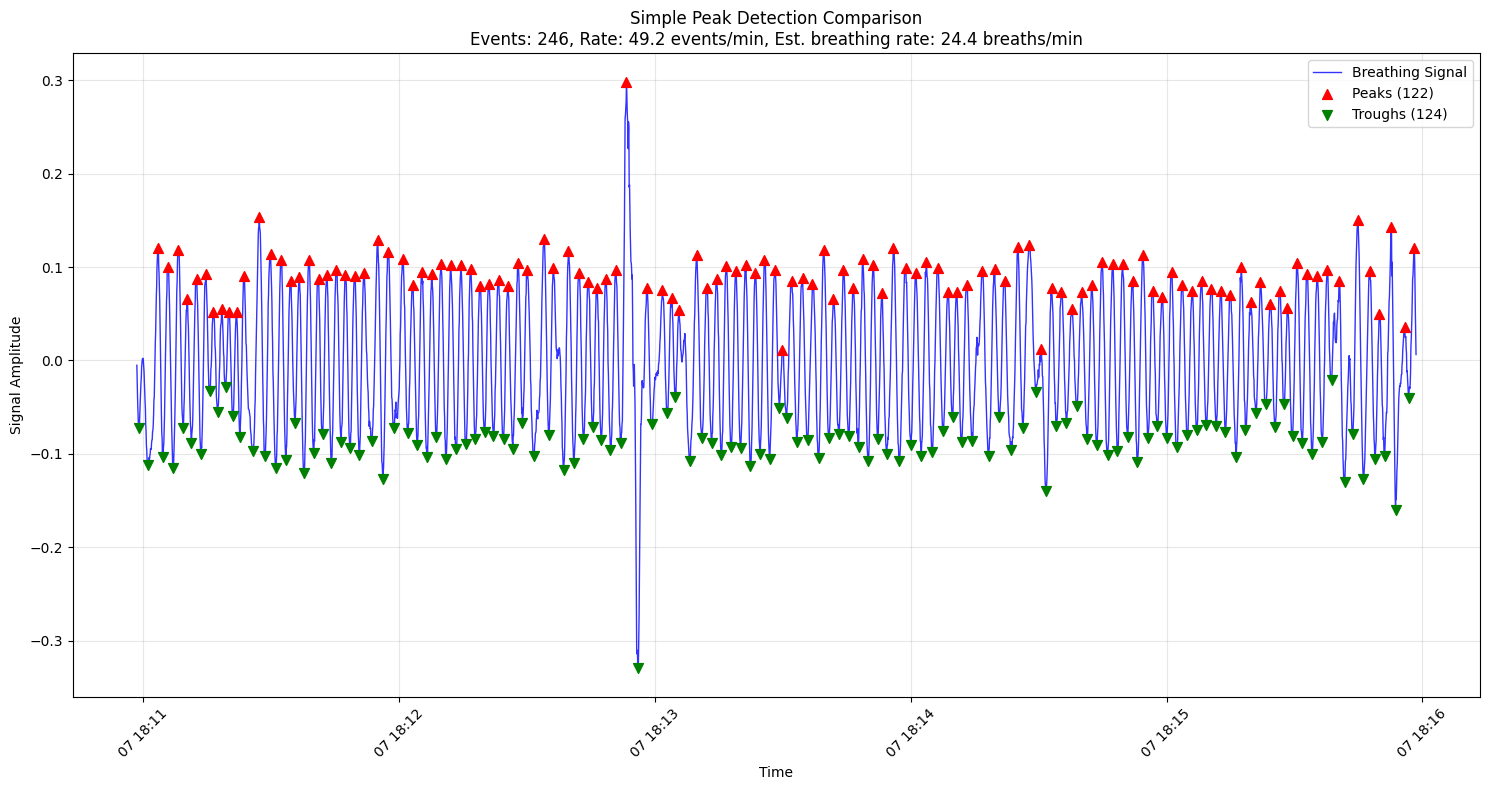

{'peaks': 122, 'troughs': 124, 'events_per_minute': 49.2, 'breaths_per_minute': 24.4}


In [19]:
# 1. Run comprehensive diagnosis
stats = diagnose_breath_detection_issues(respeck_df)
print(stats)
# 2. Plot with simple peak detection for comparison  
simple_results = plot_signal_with_simple_detection(respeck_df, start_minutes=10, duration_minutes=5)
print(simple_results)


In [ ]:
from scipy.signal import find_peaks, savgol_filter
import pandas as pd
import numpy as np

def simple_breath_detection(df, method='peaks', sensitivity='medium'):
    """
    Simple, robust breath detection using peak finding instead of adaptive thresholding.
    This works much better for respiratory patient data.
    
    Parameters:
    - df: DataFrame with breathingSignal and timestamp columns
    - method: 'peaks' (peak-based) or 'zero_crossing' (zero-crossing based)
    - sensitivity: 'low', 'medium', 'high'
    """
    
    signal = df['breathingSignal'].dropna().values
    timestamps = df.loc[df['breathingSignal'].notna(), 'timestamp'].values
    
    # Sensitivity settings
    sensitivity_params = {
        'low': {'height_factor': 0.3, 'distance_sec': 2.0, 'prominence_factor': 0.2},
        'medium': {'height_factor': 0.15, 'distance_sec': 1.5, 'prominence_factor': 0.1},
        'high': {'height_factor': 0.05, 'distance_sec': 1.0, 'prominence_factor': 0.05}
    }
    
    params = sensitivity_params[sensitivity]
    
    # Calculate sampling rate
    time_diffs = pd.Series(timestamps).diff().dropna()
    avg_sample_period = time_diffs.apply(lambda x: x.total_seconds()).mean()
    sampling_rate = 1 / avg_sample_period
    
    # Convert distance from seconds to samples
    min_distance = int(params['distance_sec'] * sampling_rate)
    
    if method == 'peaks':
        # Method 1: Peak-based detection (what worked in the simple version)
        
        # Find peaks (inspirations)
        height_threshold = np.std(signal) * params['height_factor']
        prominence_threshold = np.std(signal) * params['prominence_factor']
        
        peaks, peak_props = find_peaks(
            signal, 
            height=height_threshold,
            distance=min_distance,
            prominence=prominence_threshold
        )
        
        # Find troughs (exhalations)
        troughs, trough_props = find_peaks(
            -signal,
            height=height_threshold,
            distance=min_distance, 
            prominence=prominence_threshold
        )
        
        # Create breath events dataframe
        breath_events = []
        
        # Add inspirations
        for peak_idx in peaks:
            if peak_idx < len(timestamps):
                breath_events.append({
                    'type': 'Inhalation',
                    'index': peak_idx,
                    'timestamp': timestamps[peak_idx],
                    'amplitude': signal[peak_idx],
                    'event_type': 'peak'
                })
        
        # Add exhalations  
        for trough_idx in troughs:
            if trough_idx < len(timestamps):
                breath_events.append({
                    'type': 'Exhalation', 
                    'index': trough_idx,
                    'timestamp': timestamps[trough_idx],
                    'amplitude': signal[trough_idx],
                    'event_type': 'trough'
                })
        
        total_events = len(peaks) + len(troughs)
        breathing_cycles = min(len(peaks), len(troughs))  # Complete cycles
        
        print(f"Peak-based detection ({sensitivity} sensitivity):")
        print(f"  Peaks (inspirations): {len(peaks)}")
        print(f"  Troughs (exhalations): {len(troughs)}")
        print(f"  Complete breathing cycles: {breathing_cycles}")
        
    elif method == 'zero_crossing':
        # Method 2: Zero-crossing based detection
        
        # Smooth the signal slightly to reduce noise-induced crossings
        smoothed_signal = savgol_filter(signal, window_length=5, polyorder=2)
        
        # Find zero crossings
        zero_crossings = []
        for i in range(1, len(smoothed_signal)):
            if smoothed_signal[i-1] * smoothed_signal[i] < 0:  # Sign change
                zero_crossings.append(i)
        
        # Filter zero crossings by minimum distance
        filtered_crossings = []
        last_crossing = -float('inf')
        
        for crossing in zero_crossings:
            if crossing - last_crossing >= min_distance:
                filtered_crossings.append(crossing)
                last_crossing = crossing
        
        # Classify crossings as inspirations (negative to positive) or exhalations (positive to negative)
        breath_events = []
        inspirations = 0
        exhalations = 0
        
        for crossing_idx in filtered_crossings:
            if crossing_idx > 0 and crossing_idx < len(smoothed_signal):
                if smoothed_signal[crossing_idx-1] < 0 and smoothed_signal[crossing_idx] >= 0:
                    # Inspiration start (crossing from negative to positive)
                    breath_events.append({
                        'type': 'Inhalation',
                        'index': crossing_idx,
                        'timestamp': timestamps[crossing_idx],
                        'amplitude': signal[crossing_idx], 
                        'event_type': 'zero_crossing'
                    })
                    inspirations += 1
                elif smoothed_signal[crossing_idx-1] > 0 and smoothed_signal[crossing_idx] <= 0:
                    # Exhalation start (crossing from positive to negative)
                    breath_events.append({
                        'type': 'Exhalation',
                        'index': crossing_idx, 
                        'timestamp': timestamps[crossing_idx],
                        'amplitude': signal[crossing_idx],
                        'event_type': 'zero_crossing'
                    })
                    exhalations += 1
        
        total_events = len(filtered_crossings)
        breathing_cycles = min(inspirations, exhalations)
        
        print(f"Zero-crossing detection ({sensitivity} sensitivity):")
        print(f"  Inspirations: {inspirations}")
        print(f"  Exhalations: {exhalations}")  
        print(f"  Complete breathing cycles: {breathing_cycles}")
    
    # Convert to DataFrame
    breath_df = pd.DataFrame(breath_events)
    if not breath_df.empty:
        breath_df = breath_df.sort_values('timestamp').reset_index(drop=True)
    
    # Calculate breathing rate
    duration_minutes = (timestamps[-1] - timestamps[0]) / pd.Timedelta(minutes=1)
    
    if duration_minutes > 0:
        events_per_minute = total_events / duration_minutes
        breaths_per_minute = breathing_cycles / duration_minutes
    else:
        events_per_minute = 0
        breaths_per_minute = 0
    
    print(f"  Duration: {duration_minutes:.1f} minutes")
    print(f"  Events per minute: {events_per_minute:.1f}")
    print(f"  Breathing rate: {breaths_per_minute:.1f} breaths/minute")
    
    return breath_df, {
        'total_events': total_events,
        'breathing_cycles': breathing_cycles,  
        'events_per_minute': events_per_minute,
        'breaths_per_minute': breaths_per_minute,
        'duration_minutes': duration_minutes,
        'method': method,
        'sensitivity': sensitivity
    }

def compare_breath_methods(df):
    """
    Compare different breath detection methods
    """
    print("COMPARING BREATH DETECTION METHODS:")
    print("=" * 50)
    
    methods = [
        ('peaks', 'medium'),
        ('peaks', 'high'), 
        ('zero_crossing', 'medium'),
        ('zero_crossing', 'high')
    ]
    
    results = {}
    
    for method, sensitivity in methods:
        print(f"\n--- {method.upper()} METHOD ({sensitivity.upper()} SENSITIVITY) ---")
        breath_df, stats = simple_breath_detection(df, method=method, sensitivity=sensitivity)
        results[f"{method}_{sensitivity}"] = {'breath_df': breath_df, 'stats': stats}
    
    print(f"\nSUMMARY:")
    print("Method\t\t\tBreaths/Min\tTotal Events")
    print("-" * 45)
    for key, result in results.items():
        method_name = key.replace('_', ' ').title()
        print(f"{method_name:<20}\t{result['stats']['breaths_per_minute']:.1f}\t\t{result['stats']['total_events']}")
    
    return results

# Usage examples:

# Method 1: Use peak detection (recommended based on your plot)
breath_df, stats = simple_breath_detection(respeck_df, method='peaks', sensitivity='medium')
print(breath_df, stats)
# Method 2: Compare all methods
all_results = compare_breath_methods(respeck_df)
print(all_results)


Peak-based detection (medium sensitivity):
  Peaks (inspirations): 5223
  Troughs (exhalations): 5306
  Complete breathing cycles: 5223
  Duration: 335.5 minutes
  Events per minute: 31.4
  Breathing rate: 15.6 breaths/minute
  ✅ Breathing rate in expected range for respiratory patients
             type   index               timestamp  amplitude event_type
0      Inhalation       9 2025-05-07 18:00:59.282   0.171436       peak
1      Exhalation      24 2025-05-07 18:01:00.482  -0.172739     trough
2      Inhalation      38 2025-05-07 18:01:01.602   0.196758       peak
3      Exhalation      51 2025-05-07 18:01:02.642  -0.165042     trough
4      Inhalation      63 2025-05-07 18:01:03.602   0.137848       peak
...           ...     ...                     ...        ...        ...
10524  Exhalation  251269 2025-05-07 23:36:21.725  -0.682738     trough
10525  Exhalation  251291 2025-05-07 23:36:23.485  -0.391236     trough
10526  Inhalation  251314 2025-05-07 23:36:25.325   0.433276    

In [ ]:
from scipy.signal import find_peaks, savgol_filter
import pandas as pd
import numpy as np

def simple_breath_detection(df, method='peaks', sensitivity='medium'):
    """
    Simple, robust breath detection using peak finding instead of adaptive thresholding.
    This works much better for respiratory patient data.
    
    Parameters:
    - df: DataFrame with breathingSignal and timestamp columns
    - method: 'peaks' (peak-based) or 'zero_crossing' (zero-crossing based)
    - sensitivity: 'low', 'medium', 'high'
    """
    
    signal = df['breathingSignal'].dropna().values
    # Get corresponding timestamps and indices for non-null values
    valid_mask = df['breathingSignal'].notna()
    timestamps = df.loc[valid_mask, 'timestamp'].values
    original_indices = df.loc[valid_mask].index.values
    
    # Sensitivity settings
    sensitivity_params = {
        'low': {'height_factor': 0.3, 'distance_sec': 2.0, 'prominence_factor': 0.2},
        'medium': {'height_factor': 0.15, 'distance_sec': 1.5, 'prominence_factor': 0.1},
        'high': {'height_factor': 0.05, 'distance_sec': 1.0, 'prominence_factor': 0.05}
    }
    
    params = sensitivity_params[sensitivity]
    
    # Calculate sampling rate
    time_diffs = pd.Series(timestamps).diff().dropna()
    avg_sample_period = time_diffs.apply(lambda x: x.total_seconds()).mean()
    sampling_rate = 1 / avg_sample_period
    
    # Convert distance from seconds to samples
    min_distance = int(params['distance_sec'] * sampling_rate)
    
    if method == 'peaks':
        # Method 1: Peak-based detection (what worked in the simple version)
        
        # Find peaks (inspirations)
        height_threshold = np.std(signal) * params['height_factor']
        prominence_threshold = np.std(signal) * params['prominence_factor']
        
        peaks, peak_props = find_peaks(
            signal, 
            height=height_threshold,
            distance=min_distance,
            prominence=prominence_threshold
        )
        
        # Find troughs (exhalations)
        troughs, trough_props = find_peaks(
            -signal,
            height=height_threshold,
            distance=min_distance, 
            prominence=prominence_threshold
        )
        
        # Create breath events dataframe
        breath_events = []
        
        # Add inspirations
        for peak_idx in peaks:
            if peak_idx < len(timestamps):
                breath_events.append({
                    'type': 'Inhalation',
                    'index': original_indices[peak_idx],  # Use original DataFrame index
                    'timestamp': timestamps[peak_idx],
                    'amplitude': signal[peak_idx],
                    'event_type': 'peak'
                })
        
        # Add exhalations  
        for trough_idx in troughs:
            if trough_idx < len(timestamps):
                breath_events.append({
                    'type': 'Exhalation', 
                    'index': original_indices[trough_idx],  # Use original DataFrame index
                    'timestamp': timestamps[trough_idx],
                    'amplitude': signal[trough_idx],
                    'event_type': 'trough'
                })
        
        total_events = len(peaks) + len(troughs)
        breathing_cycles = min(len(peaks), len(troughs))  # Complete cycles
        
        print(f"Peak-based detection ({sensitivity} sensitivity):")
        print(f"  Peaks (inspirations): {len(peaks)}")
        print(f"  Troughs (exhalations): {len(troughs)}")
        print(f"  Complete breathing cycles: {breathing_cycles}")
        
    elif method == 'zero_crossing':
        # Method 2: Zero-crossing based detection
        
        # Smooth the signal slightly to reduce noise-induced crossings
        smoothed_signal = savgol_filter(signal, window_length=5, polyorder=2)
        
        # Find zero crossings
        zero_crossings = []
        for i in range(1, len(smoothed_signal)):
            if smoothed_signal[i-1] * smoothed_signal[i] < 0:  # Sign change
                zero_crossings.append(i)
        
        # Filter zero crossings by minimum distance
        filtered_crossings = []
        last_crossing = -float('inf')
        
        for crossing in zero_crossings:
            if crossing - last_crossing >= min_distance:
                filtered_crossings.append(crossing)
                last_crossing = crossing
        
        # Classify crossings as inspirations (negative to positive) or exhalations (positive to negative)
        breath_events = []
        inspirations = 0
        exhalations = 0
        
        for crossing_idx in filtered_crossings:
            if crossing_idx > 0 and crossing_idx < len(smoothed_signal):
                if smoothed_signal[crossing_idx-1] < 0 and smoothed_signal[crossing_idx] >= 0:
                    # Inspiration start (crossing from negative to positive)
                    breath_events.append({
                        'type': 'Inhalation',
                        'index': original_indices[crossing_idx],  # Use original DataFrame index
                        'timestamp': timestamps[crossing_idx],
                        'amplitude': signal[crossing_idx], 
                        'event_type': 'zero_crossing'
                    })
                    inspirations += 1
                elif smoothed_signal[crossing_idx-1] > 0 and smoothed_signal[crossing_idx] <= 0:
                    # Exhalation start (crossing from positive to negative)
                    breath_events.append({
                        'type': 'Exhalation',
                        'index': original_indices[crossing_idx],  # Use original DataFrame index
                        'timestamp': timestamps[crossing_idx],
                        'amplitude': signal[crossing_idx],
                        'event_type': 'zero_crossing'
                    })
                    exhalations += 1
        
        total_events = len(filtered_crossings)
        breathing_cycles = min(inspirations, exhalations)
        
        print(f"Zero-crossing detection ({sensitivity} sensitivity):")
        print(f"  Inspirations: {inspirations}")
        print(f"  Exhalations: {exhalations}")  
        print(f"  Complete breathing cycles: {breathing_cycles}")
    
    # Convert to DataFrame
    breath_df = pd.DataFrame(breath_events)
    if not breath_df.empty:
        breath_df = breath_df.sort_values('timestamp').reset_index(drop=True)
    
    # Calculate breathing rate
    duration_minutes = (timestamps[-1] - timestamps[0]) / pd.Timedelta(minutes=1)
    
    if duration_minutes > 0:
        events_per_minute = total_events / duration_minutes
        breaths_per_minute = breathing_cycles / duration_minutes
    else:
        events_per_minute = 0
        breaths_per_minute = 0
    
    print(f"  Duration: {duration_minutes:.1f} minutes")
    print(f"  Events per minute: {events_per_minute:.1f}")
    print(f"  Breathing rate: {breaths_per_minute:.1f} breaths/minute")
    
    # Quality assessment
    if breaths_per_minute < 8:
        print("  ⚠️  Low breathing rate - consider higher sensitivity")
    elif breaths_per_minute > 35:
        print("  ⚠️  High breathing rate - consider lower sensitivity")
    elif 12 <= breaths_per_minute <= 30:
        print("  ✅ Breathing rate in expected range for respiratory patients")
    else:
        print("  ℹ️  Breathing rate detected - review with clinical context")
    
    return breath_df, {
        'total_events': total_events,
        'breathing_cycles': breathing_cycles,  
        'events_per_minute': events_per_minute,
        'breaths_per_minute': breaths_per_minute,
        'duration_minutes': duration_minutes,
        'method': method,
        'sensitivity': sensitivity
    }

def compare_breath_methods(df):
    """
    Compare different breath detection methods
    """
    print("COMPARING BREATH DETECTION METHODS:")
    print("=" * 50)
    
    methods = [
        ('peaks', 'medium'),
        ('peaks', 'high'), 
        ('zero_crossing', 'medium'),
        ('zero_crossing', 'high')
    ]
    
    results = {}
    
    for method, sensitivity in methods:
        print(f"\n--- {method.upper()} METHOD ({sensitivity.upper()} SENSITIVITY) ---")
        breath_df, stats = simple_breath_detection(df, method=method, sensitivity=sensitivity)
        results[f"{method}_{sensitivity}"] = {'breath_df': breath_df, 'stats': stats}
    
    print(f"\nSUMMARY:")
    print("Method\t\t\tBreaths/Min\tTotal Events")
    print("-" * 45)
    for key, result in results.items():
        method_name = key.replace('_', ' ').title()
        print(f"{method_name:<20}\t{result['stats']['breaths_per_minute']:.1f}\t\t{result['stats']['total_events']}")
    
    return results


# Method 1: Use peak detection (recommended based on your plot)
breath_df, stats = simple_breath_detection(respeck_df, method='peaks', sensitivity='medium')

# Method 2: Compare all methods
all_results = compare_breath_methods(respeck_df)

Peak-based detection (medium sensitivity):
  Peaks (inspirations): 5223
  Troughs (exhalations): 5306
  Complete breathing cycles: 5223
  Duration: 335.5 minutes
  Events per minute: 31.4
  Breathing rate: 15.6 breaths/minute
  ✅ Breathing rate in expected range for respiratory patients
COMPARING BREATH DETECTION METHODS:

--- PEAKS METHOD (MEDIUM SENSITIVITY) ---
Peak-based detection (medium sensitivity):
  Peaks (inspirations): 5223
  Troughs (exhalations): 5306
  Complete breathing cycles: 5223
  Duration: 335.5 minutes
  Events per minute: 31.4
  Breathing rate: 15.6 breaths/minute
  ✅ Breathing rate in expected range for respiratory patients

--- PEAKS METHOD (HIGH SENSITIVITY) ---
Peak-based detection (high sensitivity):
  Peaks (inspirations): 5927
  Troughs (exhalations): 5904
  Complete breathing cycles: 5904
  Duration: 335.5 minutes
  Events per minute: 35.3
  Breathing rate: 17.6 breaths/minute
  ✅ Breathing rate in expected range for respiratory patients

--- ZERO_CROSSING

In [25]:
import numpy as np
import pandas as pd

def countLocalMaximas(values):
    """Count local maxima in a signal segment"""
    count = 0
    if len(values) < 3:
        return 1
    if len(values) > 1 and values[0] > values[1]:
        count += 1
    if len(values) > 1 and values[-1] > values[-2]:
        count += 1
    for i in range(1, len(values) - 1):
        if values[i] > values[i - 1] and values[i] > values[i + 1]:
            count += 1
    return count

def countLocalMinimas(values):
    """Count local minima in a signal segment"""
    count = 0
    if len(values) < 3:
        return 1
    if len(values) > 1 and values[0] < values[1]:
        count += 1
    if len(values) > 1 and values[-1] < values[-2]:
        count += 1
    for i in range(1, len(values) - 1):
        if values[i] < values[i - 1] and values[i] < values[i + 1]:
            count += 1
    return count

def mode(arr):
    """Calculate mode of an array, returning the most frequent value"""
    if len(arr) == 0:
        return np.nan, {}, []
    
    # Handle the case where input might be float values
    rounded_array = np.round(arr).astype(int)
    unique_vals, counts = np.unique(rounded_array, return_counts=True)
    max_count_idx = np.argmax(counts)
    
    return unique_vals[max_count_idx], dict(zip(unique_vals, counts)), counts

def extractFeatures_new(df, breath_df):
    """
    Extract the same features as the original extractFeatures function,
    but using the new peak-based breath detection results.
    
    Parameters:
    - df: Original DataFrame with breathingSignal, activityLevel, activityType, timestamp
    - breath_df: Result from simple_breath_detection() with detected peaks/troughs
    
    Returns:
    - DataFrame with same structure as original extractFeatures()
    """
    
    areas = []
    extremas = []
    peakRespiratoryFlows = []
    types = []
    durations = []
    activityLevels = []
    activityTypes = []
    starts = []
    ends = []
    
    # Get arrays for faster access
    activityLevel = np.array(df.activityLevel)
    activityType = np.array(df.activityType)
    signal = np.array(df.breathingSignal)
    timestamps = list(df.timestamp)
    
    # Sort breath events by timestamp
    breath_df_sorted = breath_df.sort_values('timestamp').reset_index(drop=True)
    
    print(f"Processing {len(breath_df_sorted)} breath events...")
    
    # Group consecutive breath events into breathing cycles
    i = 0
    processed_count = 0
    
    while i < len(breath_df_sorted) - 1:
        if processed_count % 25 == 0:
            print(f"{processed_count}/~{len(breath_df_sorted)//2}... ", end=" ")
        
        current_event = breath_df_sorted.iloc[i]
        
        # Look for the next event of different type to form a breathing cycle
        next_event_idx = i + 1
        while (next_event_idx < len(breath_df_sorted) and 
               breath_df_sorted.iloc[next_event_idx]['type'] == current_event['type']):
            next_event_idx += 1
            
        if next_event_idx >= len(breath_df_sorted):
            break
            
        next_event = breath_df_sorted.iloc[next_event_idx]
        
        # Get the breath cycle boundaries
        start_idx = current_event['index']
        end_idx = next_event['index']
        
        # Ensure indices are within bounds
        if start_idx >= len(signal) or end_idx >= len(signal) or start_idx < 0 or end_idx < 0:
            i = next_event_idx
            continue
            
        # Ensure proper ordering
        if start_idx > end_idx:
            start_idx, end_idx = end_idx, start_idx
            current_event, next_event = next_event, current_event
        
        # Extract the breath cycle signal
        breath_cycle = signal[start_idx:end_idx+1]
        breath_timestamps = timestamps[start_idx:end_idx+1]
        
        if len(breath_cycle) < 2:
            i = next_event_idx
            continue
        
        # Find the breakpoint (transition from inhalation to exhalation)
        breakPoint = start_idx
        for k, val in enumerate(breath_cycle):
            if val >= 0.005:  # Same threshold as original
                breakPoint = start_idx + k
                break
        
        # Separate inhalation and exhalation phases
        inhalation = signal[start_idx:breakPoint]
        inhalation_times = timestamps[start_idx:breakPoint]
        exhalation = signal[breakPoint:end_idx+1]
        exhalation_times = timestamps[breakPoint:end_idx+1]
        
        # Calculate activity statistics for this breath cycle
        cycle_activity_level = activityLevel[start_idx:end_idx+1]
        cycle_activity_type = activityType[start_idx:end_idx+1]
        
        level = cycle_activity_level.mean() if len(cycle_activity_level) > 0 else 0
        modeType = mode(cycle_activity_type)[0] if len(cycle_activity_type) > 0 else 0
        
        # Process inhalation phase
        if len(inhalation) > 1 and len(inhalation_times) > 1:
            peak = max(abs(np.array(inhalation)))
            extrema = countLocalMaximas(inhalation)
            
            # Calculate duration and area
            duration = (inhalation_times[-1] - inhalation_times[0]).total_seconds()
            if duration > 0:
                dx = duration / len(inhalation)
                area = abs(np.trapezoid(y=inhalation, dx=dx))
            else:
                area = 0
            
            areas.append(area)
            extremas.append(extrema)
            peakRespiratoryFlows.append(peak)
            types.append("Inhalation")
            durations.append(duration)
            activityLevels.append(level)
            activityTypes.append(modeType)
            starts.append(inhalation_times[0])
            ends.append(inhalation_times[-1])
        
        # Process exhalation phase
        if len(exhalation) > 1 and len(exhalation_times) > 1:
            peak = max(abs(np.array(exhalation)))
            extrema = countLocalMinimas(exhalation)
            
            # Calculate duration and area
            duration = (exhalation_times[-1] - exhalation_times[0]).total_seconds()
            if duration > 0:
                dx = duration / len(exhalation)
                area = abs(np.trapezoid(y=exhalation, dx=dx))
            else:
                area = 0
            
            areas.append(area)
            extremas.append(extrema)
            peakRespiratoryFlows.append(peak)
            types.append("Exhalation")
            durations.append(duration)
            activityLevels.append(level)
            activityTypes.append(modeType)
            starts.append(exhalation_times[0])
            ends.append(exhalation_times[-1])
        
        processed_count += 1
        i = next_event_idx
    
    print(f"\nCompleted processing. Generated {len(areas)} breath features.")
    
    # Return DataFrame with same structure as original
    return pd.DataFrame(data={
        "type": types, 
        "area": areas, 
        "peakRespiratoryFlow": peakRespiratoryFlows, 
        "extremas": extremas, 
        "duration": durations, 
        "meanActivityLevel": activityLevels, 
        "modeActivityType": activityTypes, 
        "startTimestamp": starts, 
        "endTimestamp": ends
    })


In [26]:
new_features = extractFeatures_new(respeck_df, breath_df)

Processing 10529 breath events...
0/~5264...  25/~5264...  50/~5264...  75/~5264...  100/~5264...  125/~5264...  150/~5264...  175/~5264...  200/~5264...  225/~5264...  250/~5264...  275/~5264...  300/~5264...  325/~5264...  350/~5264...  375/~5264...  400/~5264...  425/~5264...  450/~5264...  475/~5264...  500/~5264...  525/~5264...  550/~5264...  575/~5264...  600/~5264...  625/~5264...  650/~5264...  675/~5264...  700/~5264...  725/~5264...  750/~5264...  775/~5264...  800/~5264...  825/~5264...  850/~5264...  875/~5264...  900/~5264...  925/~5264...  950/~5264...  975/~5264...  1000/~5264...  1025/~5264...  1050/~5264...  1075/~5264...  1100/~5264...  1125/~5264...  1150/~5264...  1175/~5264...  1200/~5264...  1225/~5264...  1250/~5264...  1275/~5264...  1300/~5264...  1325/~5264...  1350/~5264...  1375/~5264...  1400/~5264...  1425/~5264...  1450/~5264...  1475/~5264...  1500/~5264...  1525/~5264...  1550/~5264...  1575/~5264...  1600/~5264...  1625/~5264...  1650/~5264...  1675/~

In [27]:
print(new_features)

             type      area  peakRespiratoryFlow  extremas  duration  \
0      Exhalation  0.012474             0.172739         1      1.20   
1      Inhalation  0.055326             0.172739         1      0.56   
2      Exhalation  0.057688             0.196758         1      0.48   
3      Exhalation  0.031469             0.196758         1      1.04   
4      Inhalation  0.052605             0.165042         1      0.56   
...           ...       ...                  ...       ...       ...   
15176  Inhalation  0.932175             0.682738         5      2.88   
15177  Exhalation  0.141619             0.433276         1      0.64   
15178  Exhalation  0.088637             0.433276         1      1.12   
15179  Inhalation  0.122429             0.247703         1      0.88   
15180  Exhalation  0.077778             0.127413         3      0.80   

       meanActivityLevel  modeActivityType                   startTimestamp  \
0               0.008330                 8 2025-05-08 00

In [29]:
def compare_feature_extraction_methods(df):
    """
    Compare feature extraction between old and new breath detection methods
    """
    print("COMPARING FEATURE EXTRACTION METHODS:")
    print("=" * 50)
    
    # New method
    print("\n--- NEW PEAK DETECTION METHOD ---")
    breath_df, stats = simple_breath_detection(df, method='peaks', sensitivity='medium')
    new_features = extractFeatures_new(df, breath_df)
    
    print(f"\nNew Method Results:")
    print(f"- Total features extracted: {len(new_features)}")
    print(f"- Inhalations: {len(new_features[new_features['type'] == 'Inhalation'])}")
    print(f"- Exhalations: {len(new_features[new_features['type'] == 'Exhalation'])}")
    print(f"- Average inhalation duration: {new_features[new_features['type'] == 'Inhalation']['duration'].mean():.2f}s")
    print(f"- Average exhalation duration: {new_features[new_features['type'] == 'Exhalation']['duration'].mean():.2f}s")
    print(f"- Average peak respiratory flow: {new_features['peakRespiratoryFlow'].mean():.4f}")
    
    return new_features

compare_feature_extraction_methods(respeck_df)

COMPARING FEATURE EXTRACTION METHODS:

--- NEW PEAK DETECTION METHOD ---
Peak-based detection (medium sensitivity):
  Peaks (inspirations): 5223
  Troughs (exhalations): 5306
  Complete breathing cycles: 5223
  Duration: 335.5 minutes
  Events per minute: 31.4
  Breathing rate: 15.6 breaths/minute
  ✅ Breathing rate in expected range for respiratory patients
Processing 10529 breath events...
0/~5264...  25/~5264...  50/~5264...  75/~5264...  100/~5264...  125/~5264...  150/~5264...  175/~5264...  200/~5264...  225/~5264...  250/~5264...  275/~5264...  300/~5264...  325/~5264...  350/~5264...  375/~5264...  400/~5264...  425/~5264...  450/~5264...  475/~5264...  500/~5264...  525/~5264...  550/~5264...  575/~5264...  600/~5264...  625/~5264...  650/~5264...  675/~5264...  700/~5264...  725/~5264...  750/~5264...  775/~5264...  800/~5264...  825/~5264...  850/~5264...  875/~5264...  900/~5264...  925/~5264...  950/~5264...  975/~5264...  1000/~5264...  1025/~5264...  1050/~5264...  1075/

,type,area,peakRespiratoryFlow,extremas,duration,meanActivityLevel,modeActivityType,startTimestamp,endTimestamp
0,Exhalation,0.012474,0.172739,1,1.20,0.008330,8,2025-05-08 00:00:59.282000+06:00,2025-05-08 00:01:00.482000+06:00
1,Inhalation,0.055326,0.172739,1,0.56,0.009374,8,2025-05-08 00:01:00.482000+06:00,2025-05-08 00:01:01.042000+06:00
2,Exhalation,0.057688,0.196758,1,0.48,0.009374,8,2025-05-08 00:01:01.122000+06:00,2025-05-08 00:01:01.602000+06:00
3,Exhalation,0.031469,0.196758,1,1.04,0.010584,8,2025-05-08 00:01:01.602000+06:00,2025-05-08 00:01:02.642000+06:00
4,Inhalation,0.052605,0.165042,1,0.56,0.010751,8,2025-05-08 00:01:02.642000+06:00,2025-05-08 00:01:03.202000+06:00
...,...,...,...,...,...,...,...,...,...
15176,Inhalation,0.932175,0.682738,5,2.88,0.079980,4,2025-05-08 05:36:21.725000+06:00,2025-05-08 05:36:24.605000+06:00
15177,Exhalation,0.141619,0.433276,1,0.64,0.079980,4,2025-05-08 05:36:24.685000+06:00,2025-05-08 05:36:25.325000+06:00
15178,Exhalation,0.088637,0.433276,1,1.12,0.040217,4,2025-05-08 05:36:25.325000+06:00,2025-05-08 05:36:26.445000+06:00
15179,Inhalation,0.122429,0.247703,1,0.88,0.017574,4,2025-05-08 05:36:26.445000+06:00,2025-05-08 05:36:27.325000+06:00
